In [1]:
# Import necessary packages
using SparseArrays
using StaticArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf

include("Grid.jl")
include("Stokes.jl")

compute_timestep (generic function with 1 method)

# Chapter 8

This code solves something "close" to Gerya's Problem 8.4. I introduce markers. The code below defines the markers, which are held in a data structure. I try to modularize all of the actions involving locating the markers, interpolating properties between the markers and the regular grid, and moving the markers.

In [2]:
mutable struct Markers    
    x::Array{Float64,2}
    cell::Array{Int,2}
    rho::Array{Float64,1}
    eta::Array{Float64,1}
    nmark::Integer
    
    function Markers(grid::CartesianGrid; nmx::Integer=5,nmy::Integer=5,random::Bool=false)
        N = nmx*nmy*grid.nx*grid.ny
        mdx = grid.W/nmx/(grid.nx-1)
        mdy = grid.H/nmy/(grid.ny-1)
                
        x = Array{Float64,2}(undef,2,N)
        cell = Array{Int,2}(undef,2,N)
        rho = Array{Float64,1}(undef,N)
        eta = Array{Float64,1}(undef,N)
        
        k=1
        for i in 1:(grid.ny-1)
            for j in 1:(grid.nx-1)
                for ii in 1:nmy
                     for jj in 1:nmx
                        x[1,k] = mdx/2. + mdx*(jj-1) + mdx*nmx*(j-1) + ( random ? (rand()-0.5)*mdx : 0.0 )
                        x[2,k] = mdy/2. + mdy*(ii-1) + mdy*nmy*(i-1) + ( random ? (rand()-0.5)*mdy : 0.0 )
                        cell[1,k] = j
                        cell[2,k] = i
                        rho[k] = 0.0
                        k+=1
                    end
                end
            end
        end

        new(x,cell,rho,eta,k-1)
    end
end

In [3]:
function find_cell(x::Float64,gridx::Vector{Float64},nx::Int ; guess::Integer=nothing)
    # find the cell in the array gridx that contains the current marker
    # first, see whether the initial guess is correct.
    lower::Int = 1
    upper::Int = nx
    if guess != nothing && guess >= 1 && guess < nx
        if x >= gridx[guess] && x < gridx[guess+1]
            return guess            
        elseif guess < nx-1 && x>=gridx[guess+1] && x<gridx[guess+2]
            return guess+1
        elseif guess > 1 && x < gridx[guess] && x >= gridx[guess-1]
            return guess-1
        else
            if x>=gridx[guess+1]
                lower = guess
            else
                upper = guess+1
            end
        end
     end
    # locate cell using bisection on lower,upper
    while upper-lower > 1 
        midpoint::Int = lower + floor((upper-lower)/2)
        if x >= gridx[midpoint]
            lower = midpoint
        else
            upper = midpoint
        end
    end
    return lower
end

function find_cells!(markers::Markers,grid::CartesianGrid)
   for i in 1:markers.nmark
        markers.cell[1,i] = find_cell(markers.x[1,i] , grid.x, grid.nx, guess=markers.cell[1,i])
        markers.cell[2,i] = find_cell(markers.x[2,i] , grid.y, grid.ny, guess=markers.cell[2,i])
    end
end

function initial_conditions!(markers::Markers)
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        # my initial misunderstanding of the problem setup:
        # markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
        markers.rho[i] = mr < 1.0e5 ? 3200. : 3300.
        markers.eta[i] = mr < 1.0e5 ? 1e20 : 1e21 
    end
end

function marker_to_basic_node2(m::Markers,grid::CartesianGrid)
    weights = zeros(Float64,grid.ny,grid.nx)
    field = zeros(Float64,2,grid.ny,grid.nx)
    
    # sort the markers by increasing celly and then by increasing cellx
    
    
    Threads.@threads for j in 1:grid.nx
        local jm1 = j-1
        for i in 1:grid.ny
            local im1 = i-1
            # loop over markers
            for im in 1:markers.nmark
                local cellx::Int = m.cell[1,im]
                local celly::Int = m.cell[2,im]
                if ( cellx == j || cellx == jm1) && (celly == i || celly == im1)
                    # marker has a local contribution.
                    local wx = (m.x[1,im] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
                    local wy = (m.x[2,im] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
                    local w = (cellx == j ? 1.0-wx : wx) * (celly == i ? 1.0-wy : wy)
                    
                    field[1,i,j] += w*m.rho[im]
                    field[2,i,j] += w*m.eta[im]                    
                    weights[i,j] += w
                end  
            end
        end
    end
    field[1,:,:] = field[1,:,:] ./ weights
    field[2,:,:] = field[2,:,:] ./ weights
    
    return field[1,:,:],field[2,:,:]
end
    

function marker_to_basic_node(m::Markers,grid::CartesianGrid)
    # move quantities from the markers to the basic nodes.
    # currently moves rho and eta.
    # returns rho, eta, each as a ny-by-nx matrix
    weights = zeros(Float64,grid.ny,grid.nx)
    field = zeros(Float64,2,grid.ny,grid.nx)
    
    # loop over the markers
    for i in 1:m.nmark
        # calculate weights for four surrounding basic nodes            
        cellx::Int = m.cell[1,i]
        celly::Int = m.cell[2,i]

        local wx = (m.x[1,i] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
        local wy = (m.x[2,i] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
        #i,j
        local wt_i_j=(1.0-wx)*(1.0-wy)
        field[1,celly,cellx] += wt_i_j*m.rho[i]
        field[2,celly,cellx] += wt_i_j*m.eta[i]
        weights[celly,cellx] += wt_i_j
        #i+1,j
        local wt_i1_j = (1.0-wx)*(wy)
        field[1,celly+1,cellx] += wt_i1_j*m.rho[i]
        field[2,celly+1,cellx] += wt_i1_j*m.eta[i]
        weights[celly+1,cellx] += wt_i1_j
        #i,j+1
        local wt_i_j1 = (wx)*(1.0-wy)
        field[1,celly,cellx+1] += wt_i_j1*m.rho[i]
        field[2,celly,cellx+1] += wt_i_j1*m.eta[i]
        weights[celly,cellx+1] += wt_i_j1
        #i+1,j+1
        local wt_i1_j1 = (wx)*(wy)
        field[1,celly+1,cellx+1] += wt_i1_j1*m.rho[i]
        field[2,celly+1,cellx+1] += wt_i1_j1*m.eta[i]
        weights[celly+1,cellx+1] += wt_i1_j1
    end
    field[1,:,:] = field[1,:,:] ./ weights
    field[2,:,:] = field[2,:,:] ./ weights
    
    return field[1,:,:],field[2,:,:]
end

function basic_node_to_markers!(m::Markers,grid::CartesianGrid,field::Matrix)
    Threads.@threads for i in 1:m.nmark
        cellx = m.cell[1,i]
        celly = m.cell[2,i]
        wx::Float64 = (m.x[1,i] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
        wy::Float64 = (m.x[2,i] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
        
        m.rho[i] = (1.0-wx)*(1.0-wy)*field[celly,cellx] +
            + (wx)*(1.0-wy)*field[celly,cellx+1] +
            + (1.0-wx)*(wy)*field[celly+1,cellx] +
            + (wx)*(wy)*field[celly+1,cellx+1]
    end
end

function viscosity_to_cell_centers(grid::CartesianGrid,etas::Matrix)
    # compute the harmonic average of the viscosities at the nodal points
   etan = zeros(grid.ny,grid.nx)
   for j in 2:grid.nx
        for i in 2:grid.ny
            etan[i,j] = 1/( (1/etas[i-1,j-1] + 1/etas[i-1,j] + 1/etas[i,j-1] + 1/etas[i,j])/4. )
        end
    end
    return etan
end

function velocity_to_centers(grid::CartesianGrid,vx::Matrix,vy::Matrix)
    # compute vx and vy at cell centers
     vxc = zeros(grid.ny+1,grid.nx+1);
     vyc = zeros(grid.ny+1,grid.nx+1);
     # cell centers are offset in (-) direction from basic nodes.
     #               |
     # (center)     vx[i,j]
     #               |
     # ---vy[i,j]---(i,j)       
     for i in 2:grid.ny        # interior...
        for j in 2:grid.nx
            # left
            vxm = vx[i,j-1] # this will produce vx=0 along the left boundary
            vxp = vx[i,j]
            # top
            vym = vy[i-1,j] # vy=0 along the top boundary
            vyp = vy[i,j]
            vxc[i,j] = 0.5*(vxp+vxm)
            vyc[i,j] = 0.5*(vyp+vym)            
        end
    end
    # vx - top
    vxc[1,2:grid.nx] = vxc[2,2:grid.nx]
    # bottom
    vxc[grid.ny+1,2:grid.nx] = vxc[grid.ny,2:grid.nx]
    # left
    vxc[:,1] = -vxc[:,2]
    # right
    vxc[:,grid.nx+1] = - vxc[:,grid.nx]

    # vy - left
    vyc[2:grid.ny,1] = vyc[2:grid.ny,2]
    # vy - right
    vyc[2:grid.ny,grid.nx+1] = vyc[2:grid.ny,grid.nx]
    # vy - top
    vyc[1,:] = -vyc[2,:]
    # vy - bottom
    vyc[grid.ny+1,:] = -vyc[grid.ny,:]        
    
    return vxc,vyc
end

function velocity_to_basic_nodes(grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # this gets the velocity in a format suitable for visualization.
    # NOTE - performs a transpose on the grid!!!
    vn = Array{Float64,3}(undef,2,grid.nx,grid.ny)
    Threads.@threads for i in 1:grid.ny
        for j in 1:grid.nx
            vn[1,j,i] = 0.25*(vxc[i,j]+vxc[i+1,j]+vxc[i,j+1]+vxc[i+1,j+1])
            vn[2,j,i] = 0.25*(vyc[i,j]+vyc[i+1,j]+vyc[i,j+1]+vyc[i+1,j+1])
        end
    end
    return vn
end

function velocity_to_points(x::Matrix,cell::Matrix,grid::CartesianGrid,vxc::Matrix,vyc::Matrix;N::Int=-1)
    # compute velocity at N points given in x (2-by-N)
    # cell should contain the cells in which the points are located (2-by-N)
    # this routine assumes that the velocity (vxc and vyc) is defined at the cell centers
    if N==-1
        N = size(x,2)
    end
    mvx = Array{Float64,1}(undef,N) # velocities at specified locations
    mvy = Array{Float64,1}(undef,N) 
    Threads.@threads for i in 1:N
        cellx::Int = x[1,i] < grid.xc[cell[1,i]+1] ? cell[1,i] : cell[1,i] + 1
        celly::Int = x[2,i] < grid.yc[cell[2,i]+1] ? cell[2,i] : cell[2,i] + 1
        mdx::Float64 = (x[1,i] - grid.xc[cellx])/(grid.xc[cellx+1]-grid.xc[cellx])
        mdy::Float64 = (x[2,i] - grid.yc[celly])/(grid.yc[celly+1]-grid.yc[celly])
        mvx[i] = (1-mdx)*(1-mdy)*vxc[celly,cellx] +
            + (mdx)*(1-mdy)*vxc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vxc[celly+1,cellx] +
            + (mdx)*(mdy)*vxc[celly+1,cellx+1]
        mvy[i] = (1-mdx)*(1-mdy)*vyc[celly,cellx] +
            + (mdx)*(1-mdy)*vyc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vyc[celly+1,cellx] +
            + (mdx)*(mdy)*vyc[celly+1,cellx+1]
    end    
    return mvx,mvy
end

function velocity_to_markers(m::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # This function expects the velocities to be defined at the cell centers. vxc and vyc should each have
    # an 'extra' column and row corresponding to the ghost degrees of freedom that are needed to interpolate
    # velocities along the bottom and left of the domain.
    mvx,mvy = velocity_to_points(m.x,m.cell,grid,vxc,vyc;N=markers.nmark)
   
    return mvx,mvy
end

function move_markers!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix,dt::Float64)
    # move the markers using the 1st-order algorithm (forward Euler)
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # determine the maximal timestep
    vxmax = maximum(abs.(mvx))
    vymax = maximum(abs.(mvy))
    Threads.@threads for i in 1:markers.nmark
        markers.x[1,i] += dt*mvx[i]
        markers.x[2,i] += dt*mvy[i]
    end    
    find_cells!(markers,grid)
    return dt
end

function move_markers_rk2!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix,dt::Float64)
    # move the markers using the 2nd-order Runge-Kutta algorithm.
    # compute velocities for each marker at current position
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # compute marker location at xA, xB
    xB = Array{Float64,2}(undef,2,markers.nmark)
    Threads.@threads for i in 1:markers.nmark
        xB[1,i] = markers.x[1,i] + dt/2*mvx[i]
        xB[2,i] = markers.x[2,i] + dt/2*mvy[i]
    end
    # re-locate markers, which may now be in a different cell.
    cell = copy(markers.cell)
    Threads.@threads for i in 1:markers.nmark
        cell[1,i] = find_cell(xB[1,i], grid.x, grid.nx, guess=cell[1,i])
        cell[2,i] = find_cell(xB[2,i], grid.y, grid.ny, guess=cell[2,i])
    end
    # compute velocity at xB
    mvx,mvy = velocity_to_points(xB,cell,grid,vxc,vyc)
    # Move the markers using the velocity at xB.
    Threads.@threads for i in 1:markers.nmark
        markers.x[1,i] += dt*mvx[i]
        markers.x[2,i] += dt*mvy[i]
    end
    # re-locate markers in their new cells.
    find_cells!(markers,grid)
end

function compute_timestep(grid::CartesianGrid,vxc::Matrix,vyc::Matrix;dtmax::Float64=Inf,cfl::Float64=0.5)
    # compute the maximum timestep based on cell-centered velocities in vxc and vyc and the cfl number.
    for i in 2:grid.ny
        for j in 2:grid.nx
            dx = grid.x[j]-grid.x[j-1]
            dy = grid.y[i]-grid.y[i-1]
            dtmax = min( dtmax , cfl*dx/abs(vxc[i,j]) , cfl*dy/abs(vyc[i,j]) )                            
        end
    end
    return dtmax
end

function visualization(grid::CartesianGrid,rho::Matrix,eta::Matrix,vn::Array{Float64},pressure::Matrix,time ; filename="test.vts")
    # write the visualization output from the regular grid as a .vts file.
    vtk_grid(filename, grid.x, grid.y) do vtk
        vtk["rho"] = transpose(rho)
        vtk["viscosity"] = transpose(eta)
        # add a fake third dimension to the velocity vectors
        v3 = Array{Float64,3}(undef,3,grid.nx,grid.ny)
        v3[1:2,:,:] = vn
        v3[3,:,:] .= 0.0
        vtk["Velocity"] = v3
        vtk["pressure"] = transpose(pressure[2:end,2:end])
        vtk["TIME"] = time
    end
end

function visualization(markers::Markers,time; filename="markers.vtp")  
    p3 = Array{Float64,2}(undef,3,markers.nmark)
    p3[1:2,:] = markers.x[1:2,1:markers.nmark]
    p3[3,:] .= 0.0
    
    polys = [MeshCell(PolyData.Polys(),i:i) for i in 1:markers.nmark]
    vtk_grid(filename,p3,polys) do vtk
       vtk["density"] = markers.rho[1:markers.nmark]
       vtk["viscosity"] = markers.eta[1:markers.nmark]
       vtk["TIME"] = time
    end
end

visualization (generic function with 2 methods)

In [4]:
# convenience functions for plotting and debugging
function draw_grid(grid::CartesianGrid ; nodes::Bool=false)
   for y in grid.y
        plot([grid.x[1],grid.x[end]],[y,y],"k")
    end
    for x in grid.x
        plot([x,x],[grid.y[1],grid.y[end]],"k") 
    end
    if nodes
        for i in 1:grid.ny
            for j in 1:grid.nx
                plot(grid.y[i],grid.xc[j],"gs")
                plot(grid.yc[i],grid.x[j],"bo")
                plot(grid.yc[i],grid.xc[j],"ro")
            end
        end
    end
end

function plots(markers::Markers,grid::CartesianGrid,rho::Matrix,time)
    @views mx = markers.x[:,1:markers.nmark]
    @views mrho = markers.rho[1:markers.nmark]
    figure()
    subplot(1,2,1)
    #pcolor(grid.x,grid.y,rho)
    scatter(mx[1,:],mx[2,:],c=mrho,s=0.1)
    colorbar()
    gca().invert_yaxis()
    title(time)
    gca().set_aspect("equal")
#     draw_grid(grid)
    
    subplot(1,2,2)
    contourf(grid.x,grid.y,rho,)
    colorbar()
    gca().invert_yaxis()
    title(time)
    gca().set_aspect("equal")
end

plots (generic function with 1 method)

# Test marker-related routines
The cell below test the marker-related routines.
1. Create markers and distribute uniformly in the domain.
2. Apply the initial conditions to the markers.
3. Calculate density at the basic nodes from the markers.
4. Interpolate the density back to the markers from the basic nodes.

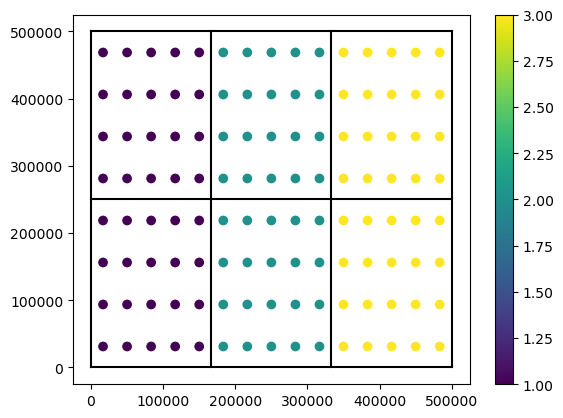

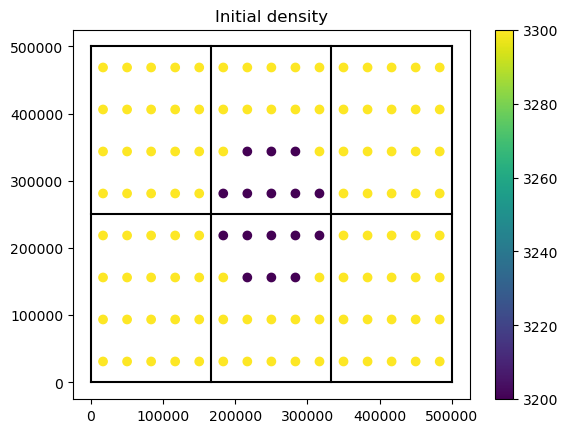

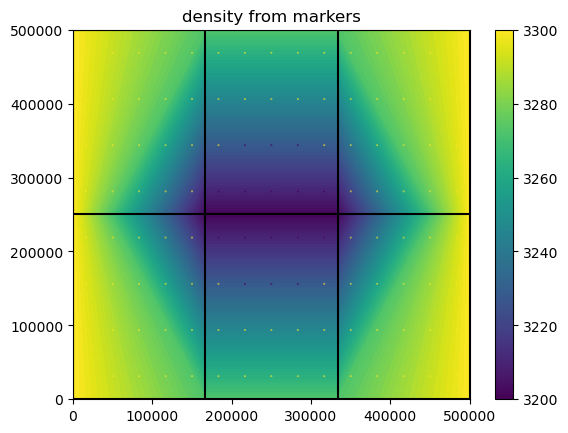

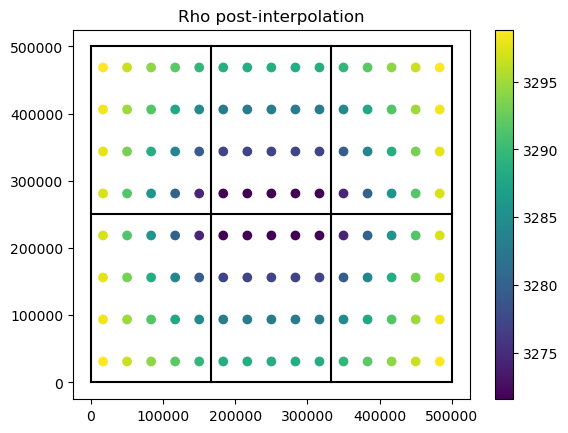

[3300.0000000000005 3291.2500000000005 3291.2500000000005 3300.0; 3300.0 3268.7500000000005 3268.7500000000005 3299.9999999999986; 3299.9999999999995 3291.2500000000005 3291.2499999999995 3300.0000000000005]

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/maxrudolph/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


1-element Vector{String}:
 "markers.vtp"

In [5]:
# Diagnostic tests on marker routines:
# Set up a grid and some markers
nx = 4
ny = 3
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 4
grid = CartesianGrid(W,H,nx,ny)
markers = Markers(grid;nmx=markx,nmy=marky,random=false)

mx = [markers.x[1,i] for i in 1:markers.nmark]
my = [markers.x[2,i] for i in 1:markers.nmark]
mcx = [markers.cell[1,i] for i in 1:markers.nmark]
mcy = [markers.cell[2,i] for i in 1:markers.nmark]

using PyPlot
figure()
scatter(mx,my,c=mcx)
draw_grid(grid)
colorbar()
show()

initial_conditions!(markers)

figure()
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
draw_grid(grid)
title("Initial density")
colorbar()
show()


rho_node,eta_node = marker_to_basic_node(markers,grid)
print(rho_node)
figure()
contourf(grid.x,grid.y,rho_node,100)
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho,s=0.1)
draw_grid(grid)
title("density from markers")
colorbar()
show()

basic_node_to_markers!(markers,grid,rho_node)

figure()
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
draw_grid(grid)
title("Rho post-interpolation")
colorbar()
show()

# visualization routines

visualization(markers,0.0)

In [13]:
# Set up the grid
nx = 201
ny = 202
W = 5e5
H = 5e5
gy = 10.0
gx =  0.0
markx = 5
marky = 5
seconds_in_year = 3.15e7
plot_interval = 1e5*seconds_in_year # plot interval in seconds
end_time = 30e6*seconds_in_year # end time in seconds
dtmax = plot_interval
bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid ; nmx=markx,nmy=marky,random=false)

# Initial conditions
initial_conditions!(markers)

time = 0.0
iout = 0
last_plot = 0.0

while time <= end_time
    # interpolate rho and eta from markers to basic nodes


    rho_new, eta_s_new = marker_to_basic_node(markers,grid) 
    println(time)
    if time > 0.0
        nanind = findall(isnan.(rho_new))
        rho_new[nanind] = rho[nanind]
        eta_s_new[nanind] = eta_s[nanind]     
    end
    
    global rho   = copy(rho_new)
    global eta_s = copy(eta_s_new)    
    # compute eta at cell centers
    eta_n = viscosity_to_cell_centers(grid,eta_s)
    
    L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    
    if time == 0.0 || time - last_plot >= plot_interval
        last_plot = time 
        name = @sprintf("output2/viz.%04d.vtr",iout)
        vn = velocity_to_basic_nodes(grid,vxc,vyc)
        visualization(grid,rho,eta_s,vn,P,time/seconds_in_year;filename=name)
        name = @sprintf("output2/markers.%04d.vtp",iout)
        visualization(markers,time/seconds_in_year;filename=name)
        iout += 1
    end
    
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    move_markers_rk2!(markers,grid,vxc,vyc,dt)
    time += dt
end

Creating Markers...
  0.033293 seconds (12 allocations: 46.466 MiB, 19.98% gc time)
0.0
4.274054131911685e11
8.54858555305063e11
1.2822303143784922e12
1.7096928796298755e12
2.1370906333028687e12
2.5643031462544624e12
2.9915651237002036e12
3.4187957112155425e12
3.845824236518947e12
4.272826234440017e12
4.699782804516546e12
5.126606430349786e12
5.553337569689745e12
5.980000282620062e12
6.406589762337496e12
6.832997738755948e12
7.259242000605607e12
7.685382038038281e12
8.111428797296356e12
8.537257434535619e12
8.962940599891525e12
9.38858891171689e12
9.814098403962938e12
1.0239321054949486e13
1.0664456201798969e13
1.1089482594936234e13
1.1514198092817588e13
1.1938743044493865e13
1.2363295159020043e13
1.2787673506233857e13
1.321176853626175e13
1.3635734555587041e13
1.4059639879852615e13
1.4483268795038445e13
1.4906654892473318e13
1.5329913670977348e13
1.5753117761789164e13
1.6176156352612621e13
1.6598932141200357e13
1.7021599145004512e13
1.7444269488111848e13
1.7866669686836062e13
1.828881

6.984011993040236e14
7.015511993040236e14
7.047011993040236e14
7.078511993040236e14
7.110011993040236e14
7.141511993040236e14
7.173011993040236e14
7.204511993040236e14
7.236011993040236e14
7.267511993040236e14
7.299011993040236e14
7.330511993040236e14
7.362011993040236e14
7.393511993040236e14
7.425011993040236e14
7.456511993040236e14
7.488011993040236e14
7.519511993040236e14
7.551011993040236e14
7.582511993040236e14
7.614011993040236e14
7.645511993040236e14
7.677011993040236e14
7.708511993040236e14
7.740011993040236e14
7.771511993040236e14
7.803011993040236e14
7.834511993040236e14
7.866011993040236e14
7.897511993040236e14
7.929011993040236e14
7.960511993040236e14
7.992011993040236e14
8.023511993040236e14
8.055011993040236e14
8.086511993040236e14
8.118011993040236e14
8.149511993040236e14
8.181011993040236e14
8.212511993040236e14
8.244011993040236e14
8.275511993040236e14
8.307011993040236e14
8.338511993040236e14
8.370011993040236e14
8.401511993040236e14
8.433011993040236e14
8.46451199304

In [7]:
# tests for a single step at high resolution.
nx = 51
ny = 51
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 5
plot_interval = 10
dtmax = 1e6*3.15e7

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid ; nmx=markx,nmy=marky,random=false)
# Initial conditions
initial_conditions!(markers)
println("markers to basic nodes...")
@time rho,eta_s = marker_to_basic_node(markers,grid)
#eta_s = 1e21 .* ones(grid.ny,grid.nx)
eta_n = 1e21 .* ones(grid.ny,grid.nx)

# rho,eta_s,eta_n = initial_conditions(grid)
bc = BoundaryConditions(0,0,0,0)
println("forming stokes...")
@time L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
println("solving stokes...")
@time solution = L\R
println("unpacking...")
@time vx,vy,P = unpack(solution,grid;ghost=true)
println("cell center velocities...")
vxc,vyc = velocity_to_centers(grid,vx,vy)
println("Computing timestep...")
@time dt=compute_timestep(grid,vxc,vyc)
println("advecting markers...")
@time move_markers_rk2!(markers,grid,vxc,vyc,dt)
println("visualization...")
vn = velocity_to_basic_nodes(grid,vxc,vyc)
@time visualization(grid,rho,eta_s,vn,P,0.0,filename="test.vtr")

Creating Markers...
  0.001631 seconds (12 allocations: 2.977 MiB)
markers to basic nodes...
  0.291086 seconds (4.06 M allocations: 63.106 MiB, 4.96% gc time)
forming stokes...
  0.024592 seconds (397.96 k allocations: 9.958 MiB, 32.08% gc time)
solving stokes...
  0.075671 seconds (71 allocations: 19.371 MiB, 15.29% gc time)
unpacking...
  0.000056 seconds (10 allocations: 63.641 KiB)
cell center velocities...
Computing timestep...
  0.001377 seconds (40.00 k allocations: 625.016 KiB)
advecting markers...
  0.090985 seconds (4.31 M allocations: 70.612 MiB)
visualization...
  0.003780 seconds (8.51 k allocations: 555.109 KiB)


1-element Vector{String}:
 "test.vtr"

In [16]:
# playing around with fieldnames to think about generalized interpolation.
getfield(markers,fieldnames(typeof(markers))[3]  )

625-element Vector{Float64}:
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
 3000.0
    ⋮
    4.0e-323
    1.6e-322
   -4.02133164116557e40
  NaN
    1.5e-322
    0.0
    7.73659253e-316
    8.487983164e-314
    3.2e-322
    2.3161157e-316
    6.91265698463696e-310
  NaN